In [1]:
%matplotlib inline

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datashader as ds
import plotnine as pln

from scipy import stats

from sklearn.preprocessing import OneHotEncoder

import datashader.transfer_functions as tf

# Import the file and preprocess it

In [43]:
data = pd.read_csv('./ML case/data.csv', parse_dates=['date_in'], dtype={'agency_rating': np.int64})

`agancy_rating`, the only ordinal variable will be treated as a numeric one for the sake of this classification.

In [44]:
data['year'] = data['date_in'].dt.year
data['month'] = data['date_in'].dt.month 
data['weekday'] = data['date_in'].dt.weekday

In [45]:
data.shape

(85195, 23)

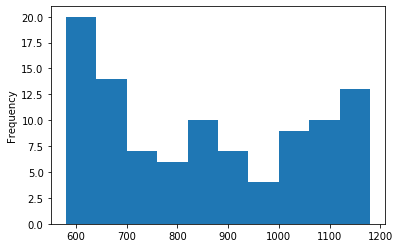

In [46]:
data['house_pk'].value_counts().plot(kind='hist')

In [47]:
data[['agency_id', 'agency_rating']].pivot_table(index='agency_id', columns='agency_rating', aggfunc=len)

agency_rating,2,3,4,5
agency_id,,,,
90,NaN,23554.0,3042.0,1969.0
121,652.0,5660.0,11310.0,7476.0
130,NaN,3121.0,5624.0,2880.0
160,NaN,6651.0,6729.0,6527.0


In [48]:
data = pd.concat([data, pd.get_dummies(data, columns=['agency_id'], drop_first=True)], sort=False)

In [9]:
data.columns

Index(['house_pk', 'agency_id', 'date_in', 'price', 'dis_water_real',
       'dis_shopping', 'no_bedrooms', 'max_persons', 'house_size', 'land_size',
       'build_year', 'renovation_year', 'apartment', 'indoor_pool', 'spa',
       'internet', 'pets_allowed', 'water_view', 'fire_stove', 'agency_rating',
       'year', 'month', 'weekday', 'agency_id_121', 'agency_id_130',
       'agency_id_160'],
      dtype='object')

# Exploratory data anlysis (EDA)

First, we will discover the relationship between the target variable and the features.

### Plot y's (price's) distribution

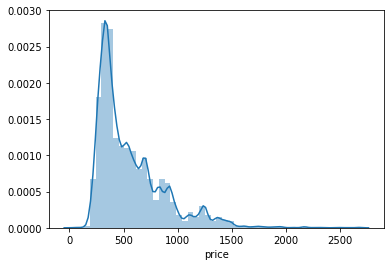

In [23]:
sns.distplot(data['price'])

As the distribution of price is highly non-normal, it will be more reasonable to work with log-normalized data.

In [49]:
data['price'] = np.log10(data['price'])

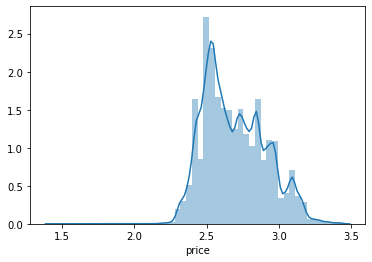

In [12]:
sns.distplot(data['price'])

### Plot mean price over time and add some context to it with all of the observations on one plot

In [70]:
holidays = pd.DataFrame({'start': ['2016-07-01', '2017-07-01', '2018-07-01'], 'finish': ['2016-08-31', '2017-08-31', '2018-08-31'], 
                         'ymin': [-np.inf, -np.inf, -np.inf], 'ymax': [np.inf, np.inf, np.inf]}, )
holidays['start'] = pd.to_datetime(holidays['start'])
holidays['finish'] = pd.to_datetime(holidays['finish'])

In [73]:
(pln.ggplot(pln.aes('date_in', 'price', group='factor(house_pk)'), data=data)
 + pln.geom_line(color='gray', alpha=0.3, size=0.5)
 + pln.geom_line(pln.aes('date_in', 'price'), data.groupby('date_in')['price'].agg('mean').to_frame().reset_index(drop=False), size=3, inherit_aes=False)
 + pln.geom_rect(pln.aes(xmin='start', xmax='finish', ymin='ymin', ymax='ymax'), holidays, fill='green', alpha=0.1, inherit_aes=False)
 + pln.labels.xlab('Date')
 + pln.labels.
 + pln.theme_bw()
 + pln.theme(axis_text_x=pln.element_text(rotation=90, hjust=0.5)))

TypeError: 'module' object is not callable

### Categorical variables

It pays off to plot the distribution with respect to the year even if it cannot be used as an explanatory variable.

In [13]:
cat_variables = ['agency_id', 'apartment', 'indoor_pool', 'spa', 'internet', 'pets_allowed', 'water_view', 'fire_stove', 'agency_rating', 'year', 
                 'month', 'weekday']

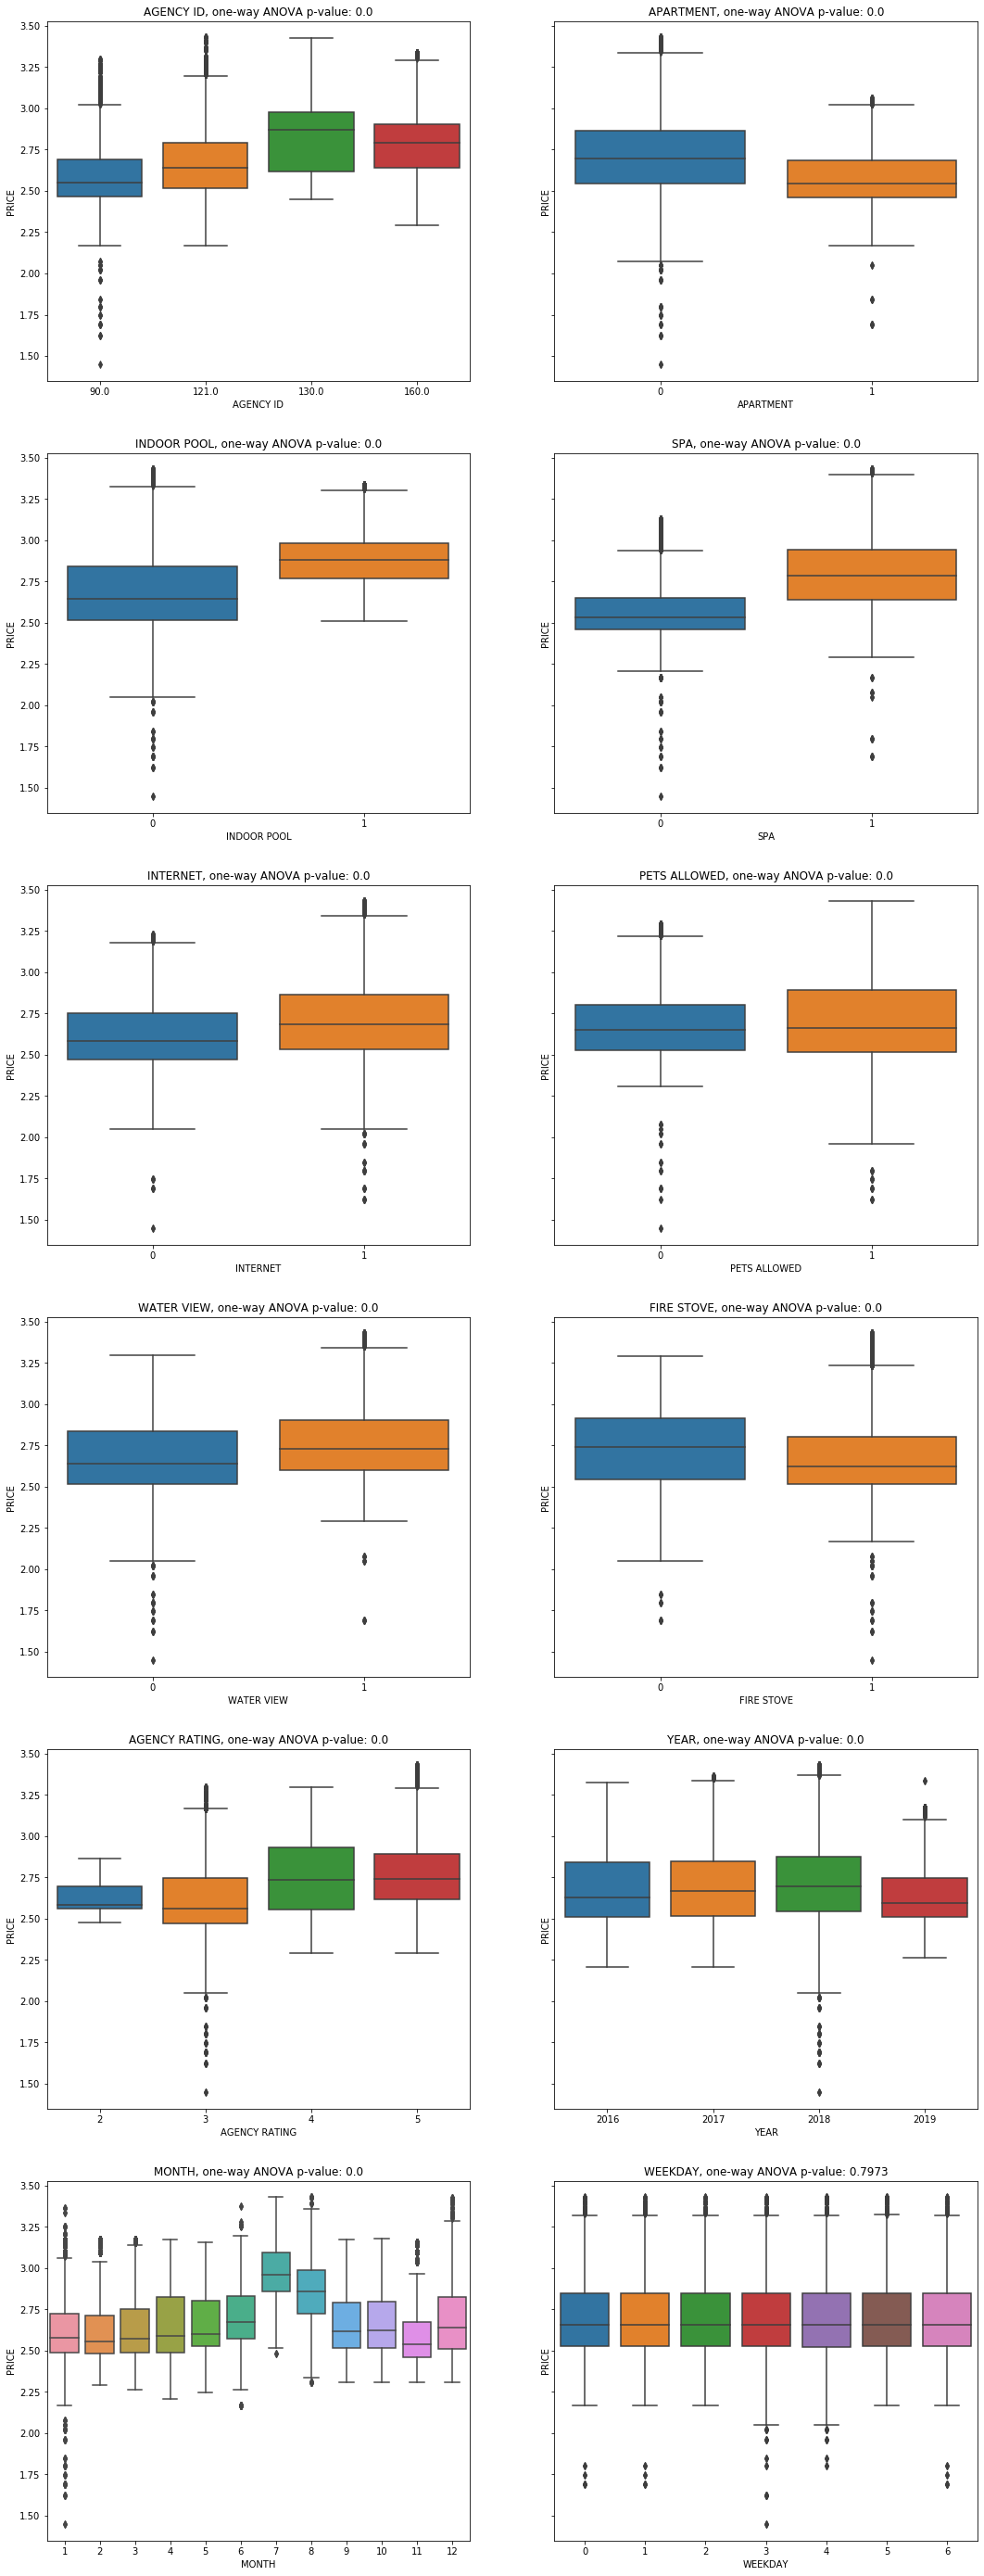

In [14]:
n_rows = len(cat_variables) // 2 + len(cat_variables) % 2
n_cols = 2
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, figsize=(18, 50))

for i, var in enumerate(cat_variables):
    var_name = var.upper().replace('_', ' ')
    sns.boxplot(data=data, x=var, y='price', ax=ax[i // 2, i % 2])
    # please mind that the data has been already log-transformed
    _, p = stats.f_oneway(*[data['price'].loc[x[1][var].index].values for x in data[var].to_frame().groupby(var, squeeze=True)])
    ax[i // 2, i % 2].set_title(f'{var_name}, one-way ANOVA p-value: {np.round(p, 4)}')
    ax[i // 2, i % 2].set_xlabel(var_name)
    ax[i // 2, i % 2].set_ylabel('PRICE')
    
# remove unused axes
if i+1 != n_rows*n_cols:
    ax.flat[-1].set_visible(False)

### Continuous variables

In [15]:
con_variables = ['dis_water_real', 'dis_shopping', 'no_bedrooms', 'max_persons', 'house_size', 'land_size', 'build_year', 'renovation_year']

Apparently, `no_bedrooms` could be treated as a categorical variable due to the low number of values it takes.

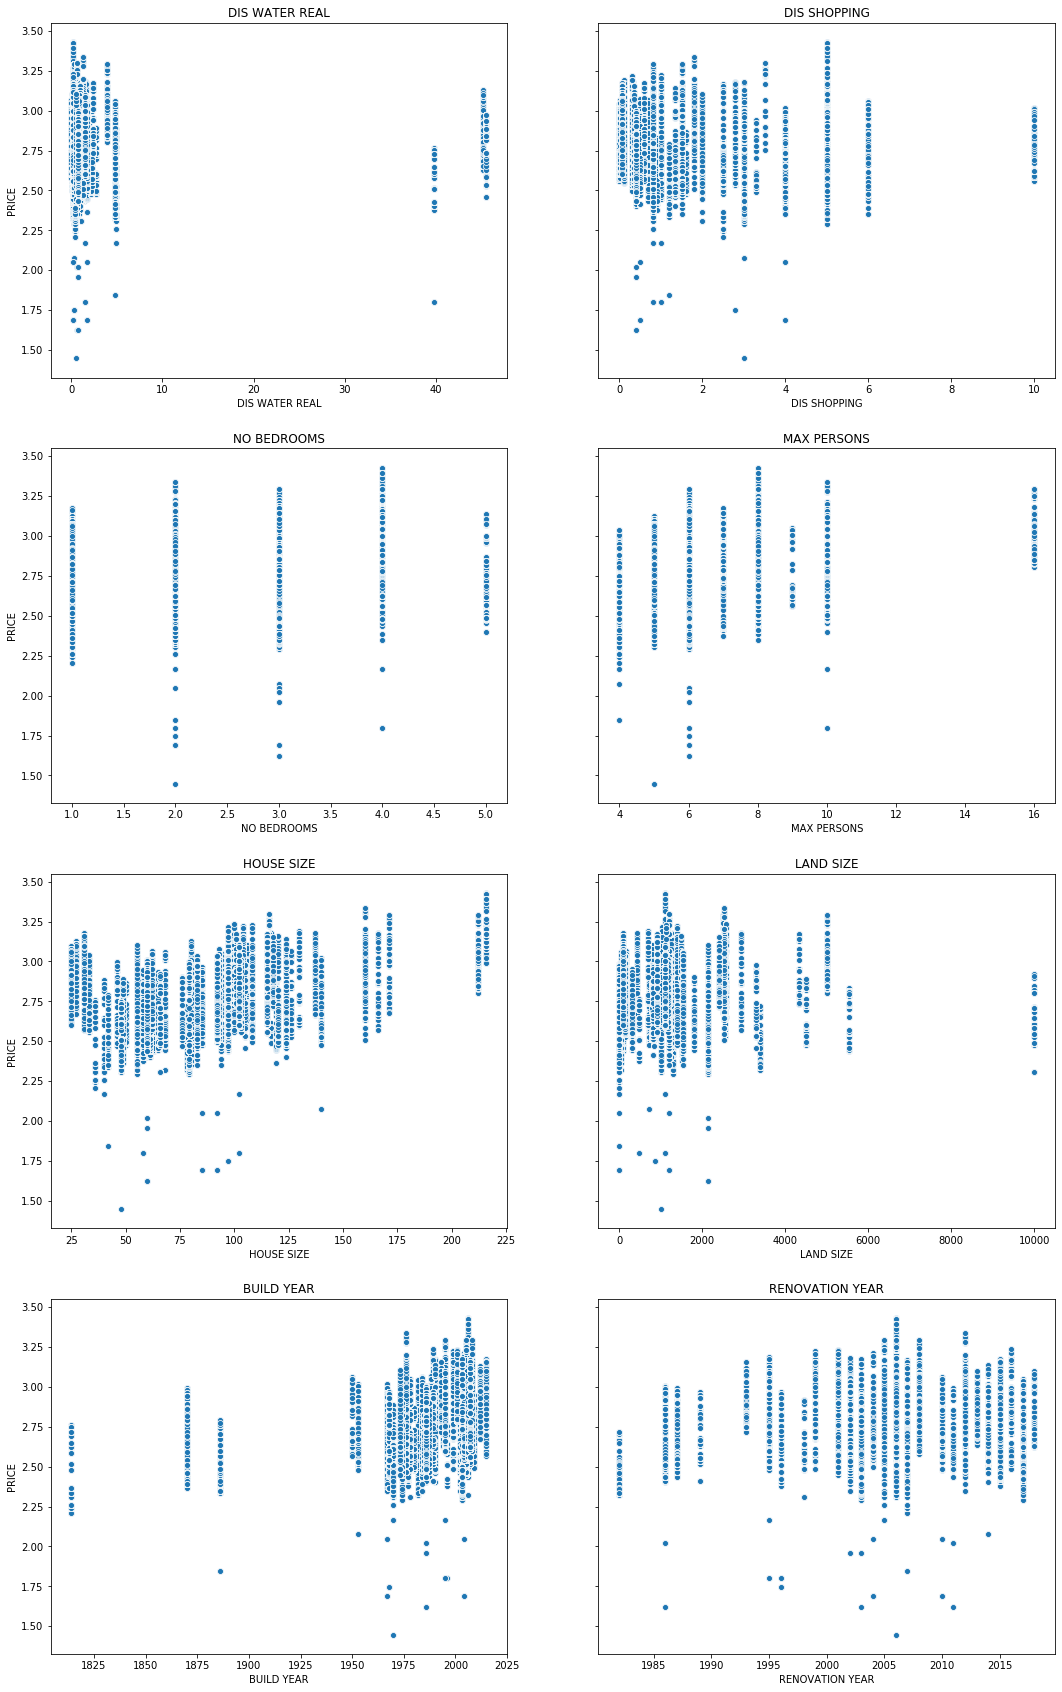

In [16]:
n_rows = len(con_variables) // 2 + len(con_variables) % 2
n_cols = 2

fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, figsize=(18, 30))

for i, var in enumerate(con_variables):
    var_name = var.upper().replace('_', ' ')
    sns.scatterplot(data=data, x=var, y='price', ax=ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_title(var_name)
    ax[i // 2, i % 2].set_xlabel(var_name)
    ax[i // 2, i % 2].set_ylabel('PRICE')
    
# remove unused axes
if i+1 != n_rows*n_cols:
    ax.flat[-1].set_visible(False)

### Correlation between features

In [17]:
all_variables = cat_variables + con_variables

In [19]:
palette = sns.xkcd_palette(colors=["windows blue", "amber"])
col_mapping = [palette[0] if var in cat_variables else palette[1] for var in all_variables]

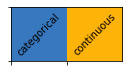

In [24]:
# legend for the rectangles on the plot
sns.palplot(palette)
for i, val in enumerate(['categorical', 'continuous']):
    plt.text(i, 0, val, horizontalalignment='center', verticalalignment='center', rotation=45)
plt.show()

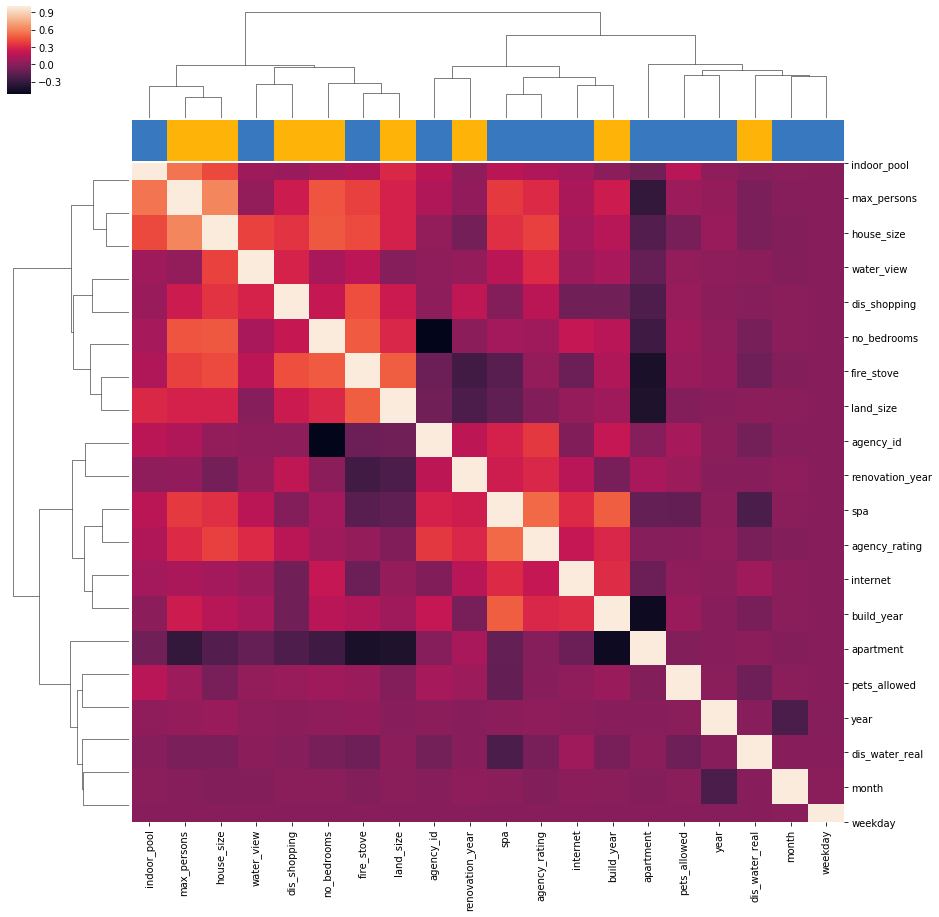

In [23]:
sns.clustermap(data[all_variables].corr(method='pearson'), method='ward', figsize=(15, 15), row_cluster=True, col_cluster=True, col_colors=col_mapping)

# Regression model, solely on tabular data, to predict price